# DS-2: Heart-Disease Prediction  
**Task vii – Automated Feature Extraction & Classification**

Dataset `DS2.csv`  
Goal: Predict `target` (1 = disease, 0 = healthy)

Feature-extraction techniques  
1. **PCA** – linear, variance-preserving  
2. **t-SNE** – non-linear, manifold-learning (mainly for visual insight, but we’ll still feed its low-dim representations to classifiers)

Classifiers  
* Logistic Regression (baseline linear)  
* Random Forest (non-linear, ensemble)

We’ll report **accuracy, precision, recall, F1, confusion-matrix** for each (technique × model) combination.


In [1]:
# 1️⃣ Environment & libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns   # optional, for prettier matrices
RANDOM_STATE = 42


## 2️⃣ Load the data


In [2]:
df = pd.read_csv('/content/DS2.csv')  # adjust path if needed
display(df.head())
print(f'Shape: {df.shape}')


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Shape: (303, 14)


### 2.1 Quick sanity checks


In [3]:
print(df.info())
print(df.isna().sum())
print(df['target'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB
None
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype:

## 3️⃣ Pre-processing pipeline

* **Numeric** → StandardScaler  
* **Categorical** → OneHotEncoder  
The target column is `target`; all others are features.


In [4]:
target_col = 'target'
X = df.drop(columns=[target_col])
y = df[target_col]

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

X.head(20)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0
9,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,0.0,7.0


## 4️⃣ Train-test split (80 / 20)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(f'Train: {X_train.shape}, Test: {X_test.shape}')


Train: (242, 13), Test: (61, 13)


## 5️⃣ Feature Extraction 🔧 — **PCA**

We’ll keep enough components to explain **95 % variance** (you can tweak).


In [6]:
pca = PCA(n_components=0.95, random_state=RANDOM_STATE)

pca_pipe = Pipeline(steps=[
    ('pre', preprocess),
    ('pca', pca)
])

X_train_pca = pca_pipe.fit_transform(X_train)
X_test_pca  = pca_pipe.transform(X_test)

print(f'PCA components chosen: {pca.n_components_}')


PCA components chosen: 12


## 6️⃣ Classification on PCA features



=== LogReg (PCA) ===
Accuracy : 0.5902


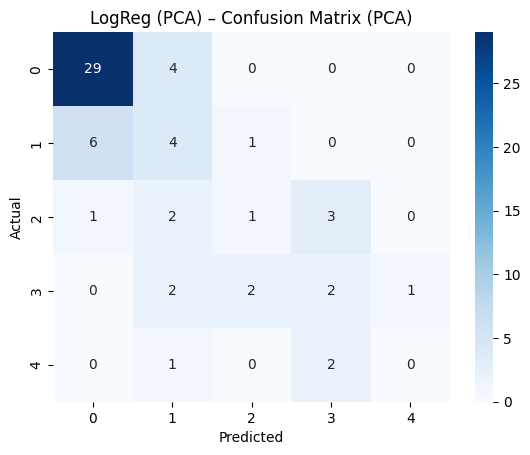


=== RF (PCA) ===
Accuracy : 0.5902


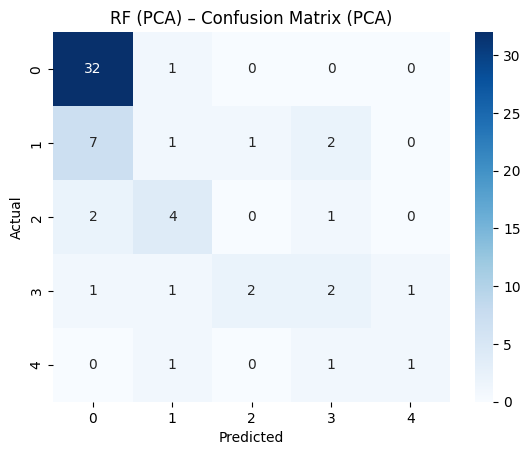

In [10]:
models = {
    'LogReg':  LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'RF':      RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE)
}

def evaluate(name, clf, X_tr, X_te):
    clf.fit(X_tr, y_train)
    y_pred = clf.predict(X_te)
    print(f'\n=== {name} ===')
    print(f'Accuracy : {accuracy_score(y_test, y_pred):.4f}')



    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} – Confusion Matrix (PCA)')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.show()

for name, clf in models.items():
    evaluate(f'{name} (PCA)', clf, X_train_pca, X_test_pca)
